In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm
import tempfile
from itertools import product

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

## Load peaks

In [3]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_noise')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me3', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me3']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [5]:
def load_peaks(path):
    df_fdr_macs2 = load_peaks_fdr(os.path.join(path, 'macs2'), '.narrowPeak', ['0.05'])
    df_fdr_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_fdr_macs2))

    df_fdr_macs2broad = load_peaks_fdr(os.path.join(path, 'macs2'), '.broadPeak', ['0.1'])
    df_fdr_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_fdr_macs2broad))

    df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), 'summary-FDR', ['0.01'])
    df_fdr_sicer['tool'] = 'SICER'
    print('SICER', len(df_fdr_sicer))

    df_fdr_span = load_peaks_fdr(os.path.join(path, 'span'), '.peak', ['0.05'])
    df_fdr_span['tool'] = 'SPAN'
    print('SPAN', len(df_fdr_span))

    return pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span]).reset_index(drop=True)

In [6]:
df_fdr_peaks_noise = load_peaks(GSE26320_PATH_HG38)
df_fdr_peaks_noise['quality'] = 0
for mln in [7, 5, 2, 1]:
    df_fdr_peaks_noise.loc[[f'{mln}mln' in file for file in df_fdr_peaks_noise['file']], 'quality'] = mln
df_fdr_original_peaks = load_peaks(os.path.expanduser('~/data/2023_GSE26320'))
df_fdr_original_peaks['quality'] = 10
df_fdr_peaks = pd.concat([df_fdr_peaks_noise, df_fdr_original_peaks]).reset_index(drop=True)

  0%|          | 0/952 [00:00<?, ?it/s]

MACS2 24


  0%|          | 0/952 [00:00<?, ?it/s]

MACS2 broad 24


  0%|          | 0/119 [00:00<?, ?it/s]

SICER 24


  0%|          | 0/122 [00:00<?, ?it/s]

SPAN 24


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 16


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 16


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 16


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 16


In [7]:
df_fdr_peaks[df_fdr_peaks['tool'] == 'SICER']

,file,modification,cell,replicate,fdr,peaks,avlength,tool,quality
48,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,K562,rep2,0.01,20717,4477.959309,SICER,7
49,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,Huvec,rep1,0.01,19566,2397.783604,SICER,5
50,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,GM12878,rep2,0.01,10963,3490.343610,SICER,1
51,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,GM12878,rep1,0.01,23190,5264.916343,SICER,7
52,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,GM12878,rep1,0.01,13370,4356.172775,SICER,2
53,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,K562,rep1,0.01,7661,3060.454118,SICER,1
54,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,Huvec,rep1,0.01,9506,2163.843257,SICER,1
55,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,Huvec,rep2,0.01,9305,2915.883396,SICER,1
56,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,K562,rep1,0.01,20095,2985.334909,SICER,5
57,/home/jetbrains/data/2023_GSE26320_noise/sicer...,H3K4me3,Huvec,rep1,0.01,23187,2325.407038,SICER,7


In [8]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

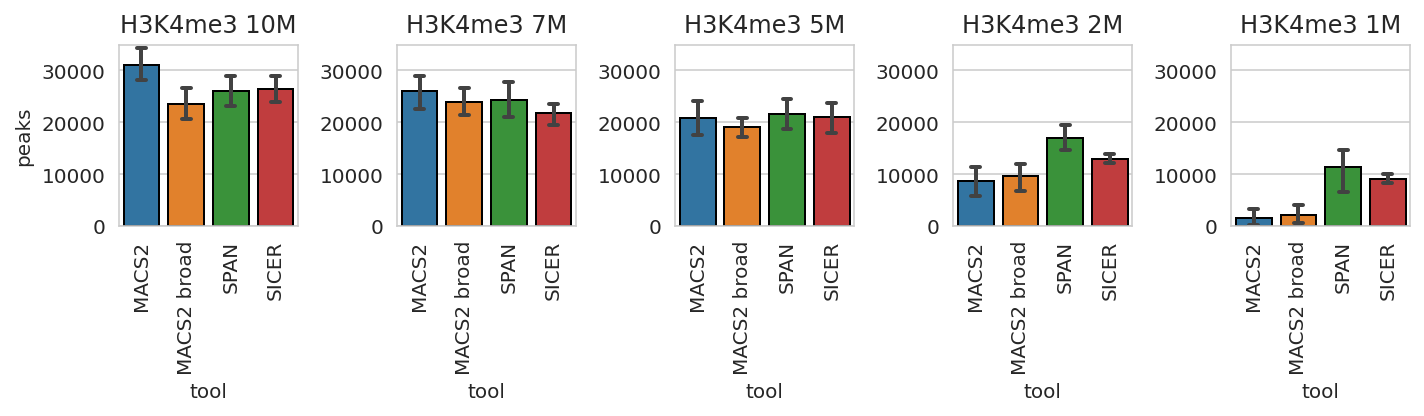

In [9]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, mln in enumerate([10, 7, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=df_fdr_peaks[df_fdr_peaks['quality']==mln],
                            x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.set_ylim(0, 35_000)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(f'H3K4me3 {mln}M')
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

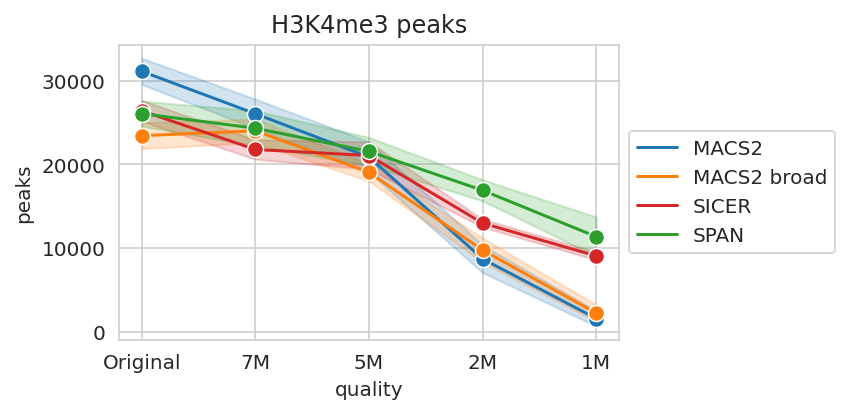

In [10]:
df_fdr_peaks['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    df_fdr_peaks.loc[df_fdr_peaks['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=df_fdr_peaks,
                         x='q', y='peaks', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_peaks2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000))
    t['quality'] = mln
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,quality,name
1036354,4999.0,10,MACS2 broad
1380339,978.0,10,SPAN
1210575,3199.0,10,SICER
1258088,2599.0,10,SICER
75121,270.0,5,MACS2
19029,1326.0,2,MACS2
670485,2749.0,1,SPAN
429468,3399.0,1,SICER
233031,621.0,7,MACS2 broad
190512,785.0,7,MACS2 broad


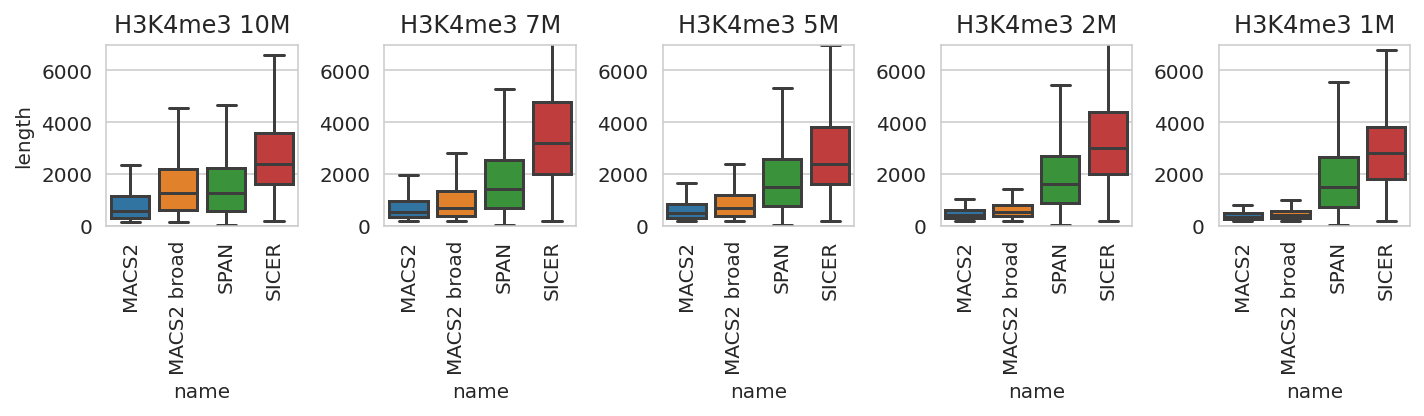

In [12]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, mln in enumerate([10, 7, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=t[t['quality']==mln], x='name', y='length', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            showfliers=False)
    ax.title.set_text(f'H3K4me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([-10, 7000])
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

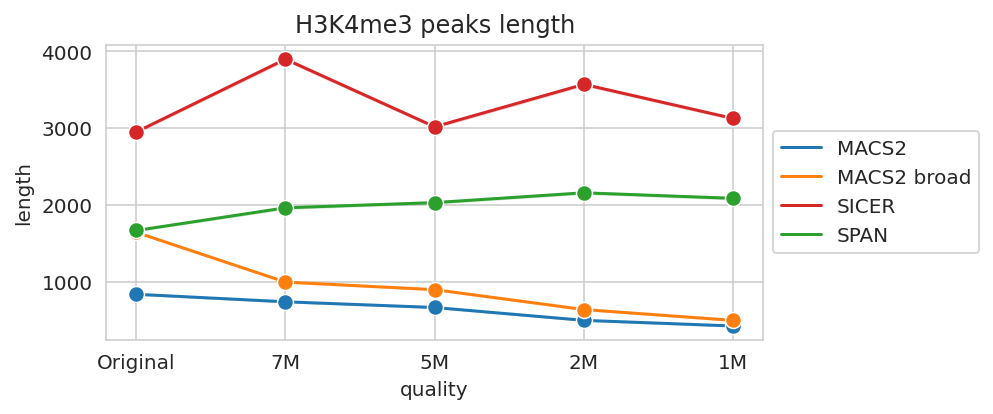

In [13]:
t['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(7, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='length', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks length')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_lengths2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Footprint

In [14]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    ts.append((mln, tool, coverage))
t = pd.DataFrame(data=ts, columns=['quality', 'name', 'coverage'])
del ts
t.sample(1)

0it [00:00, ?it/s]

,quality,name,coverage
76,1,SPAN,44616941.0


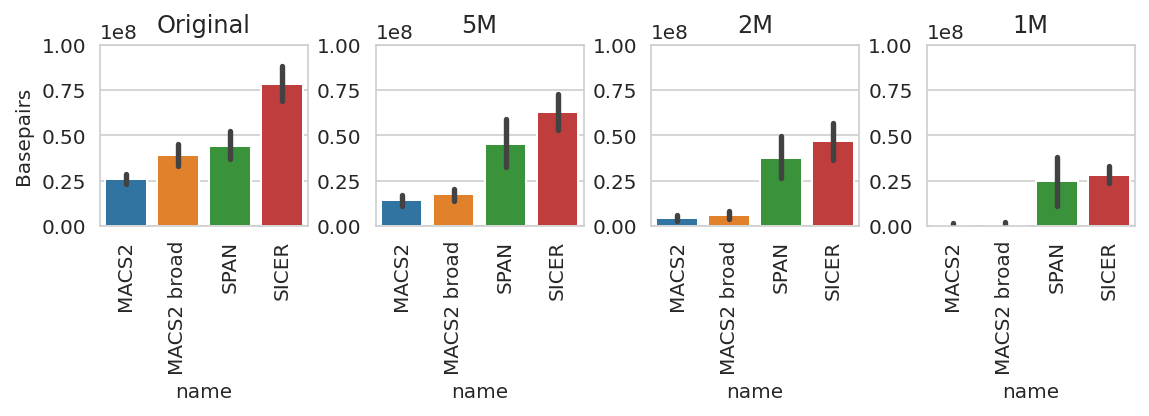

In [15]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, mln in enumerate([10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=t[t['quality']==mln], x='name', y='coverage', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'{mln}M' if mln != 10 else 'Original')
    ax.set_ylabel('Basepairs')
    ax.set_ylim([0, 1e8])
    ax.xaxis.set_tick_params(rotation=90)
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

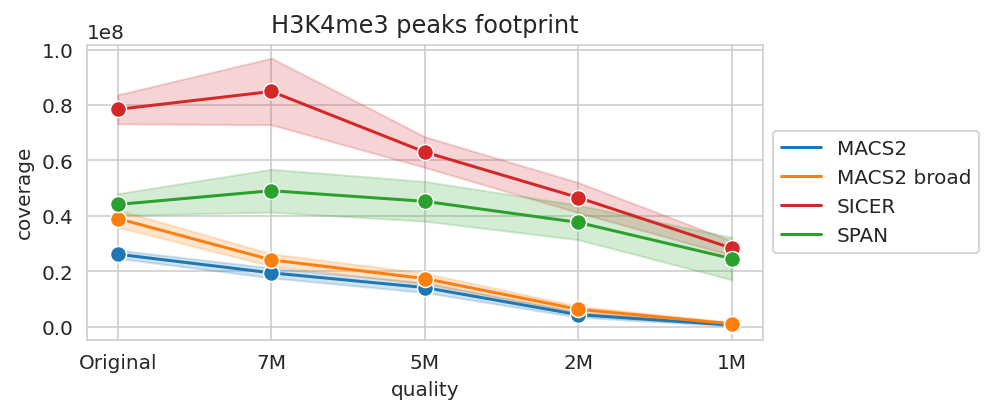

In [16]:
t['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(7, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='coverage', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks footprint')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_sumlength2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard vs original peaks

In [17]:
import tempfile
from itertools import product

mln_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'full_peaks', 'full_peaks_len',
             'quality', 'mln_peaks', 'mln_peaks_len',
             'full_overlap', 'mln_overlap',
             'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for c, r, tool in tqdm(product(GSE26320_CELLS, GSE26320_REPS, TOOLS)):
    print(c, r, tool)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                     (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r) &
                     (df_fdr_peaks['quality'] == 10)]
    if len(t) == 0:
        continue
    full_file = sorted_file(t['file'].values[0])
    full_peaks = lines(full_file)
    full_peaks_len = int(bedl(full_file).sum())
    for mln in [7, 5, 2, 1]:
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r) &
                         (df_fdr_peaks['quality'] == mln)]
        if len(t) == 0:
            continue
        mln_file = sorted_file(t['file'].values[0])
        mln_peaks = lines(mln_file)
        mln_peaks_len = int(bedl(mln_file).sum())
        !bedtools intersect -a {full_file} -b {mln_file} -wa -u > {tf}
        full_peaks_overlap = lines(tf)
        !bedtools intersect -b {full_file} -a {mln_file} -wa -u > {tf}
        mln_peaks_overlap = lines(tf)
        !bedtools intersect -a {full_file} -b {mln_file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        mln_bench_df.loc[len(mln_bench_df)] = \
            (c, r, tool,
             full_peaks, full_peaks_len,
             mln, mln_peaks, mln_peaks_len,
             full_peaks_overlap, mln_peaks_overlap,
             overlap_len)

display(mln_bench_df.sample())

0it [00:00, ?it/s]

GM12878 rep1 MACS2
GM12878 rep1 MACS2 broad
GM12878 rep1 SPAN
GM12878 rep1 SICER
GM12878 rep2 MACS2
GM12878 rep2 MACS2 broad
GM12878 rep2 SPAN
GM12878 rep2 SICER
HMEC rep1 MACS2
HMEC rep1 MACS2 broad
HMEC rep1 SPAN
HMEC rep1 SICER
HMEC rep2 MACS2
HMEC rep2 MACS2 broad
HMEC rep2 SPAN
HMEC rep2 SICER
HSMM rep1 MACS2
HSMM rep1 MACS2 broad
HSMM rep1 SPAN
HSMM rep1 SICER
HSMM rep2 MACS2
HSMM rep2 MACS2 broad
HSMM rep2 SPAN
HSMM rep2 SICER
K562 rep1 MACS2
K562 rep1 MACS2 broad
K562 rep1 SPAN
K562 rep1 SICER
K562 rep2 MACS2
K562 rep2 MACS2 broad
K562 rep2 SPAN
K562 rep2 SICER
NHEK rep1 MACS2
NHEK rep1 MACS2 broad
NHEK rep1 SPAN
NHEK rep1 SICER
NHEK rep2 MACS2
NHEK rep2 MACS2 broad
NHEK rep2 SPAN
NHEK rep2 SICER
NHLF rep1 MACS2
NHLF rep1 MACS2 broad
NHLF rep1 SPAN
NHLF rep1 SICER
NHLF rep2 MACS2
NHLF rep2 MACS2 broad
NHLF rep2 SPAN
NHLF rep2 SICER
H1 rep1 MACS2
H1 rep1 MACS2 broad
H1 rep1 SPAN
H1 rep1 SICER
H1 rep2 MACS2
H1 rep2 MACS2 broad
H1 rep2 SPAN
H1 rep2 SICER
Huvec rep1 MACS2
Huvec rep

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len
30,GM12878,rep2,SICER,31862,110795738,2,15071,64283729,14639,15070,58871147


In [18]:
mln_bench_df['precision'] = [d(a, b) for a, b in zip(mln_bench_df['mln_overlap'], mln_bench_df['mln_peaks'])]
mln_bench_df['sensitivity'] = [d(a, b) for a, b in zip(mln_bench_df['full_overlap'], mln_bench_df['full_peaks'])]
mln_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(mln_bench_df['sensitivity'], mln_bench_df['precision'])]

mln_bench_df['precision_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['mln_peaks_len'])]
mln_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['full_peaks_len'])]
mln_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                          for s, p in zip(mln_bench_df['sensitivity_len'], mln_bench_df['precision_len'])]

mln_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(mln_bench_df['full_peaks_len'], mln_bench_df['mln_peaks_len'], mln_bench_df['overlap_len'])
]
mln_bench_df.sample(1)

,cell,replicate,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard
12,GM12878,rep1,SICER,32672,119433328,7,23190,122093410,24244,23119,105287556,0.996938,0.742042,0.850809,0.862352,0.881559,0.87185,0.772814


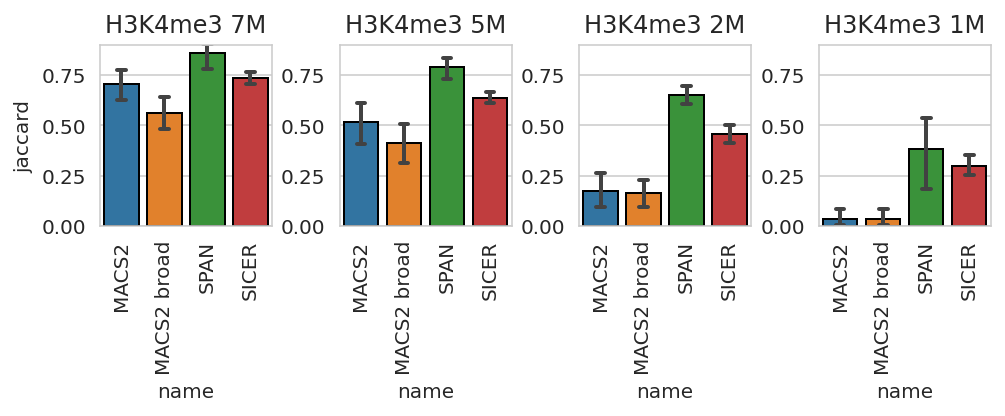

In [19]:
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, mln in enumerate([7, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=mln_bench_df[mln_bench_df['quality']==mln],
                            x='name', y='jaccard', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'H3K4me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([0, 0.9])
    if i > 0:
        ax.set_ylabel(None)

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

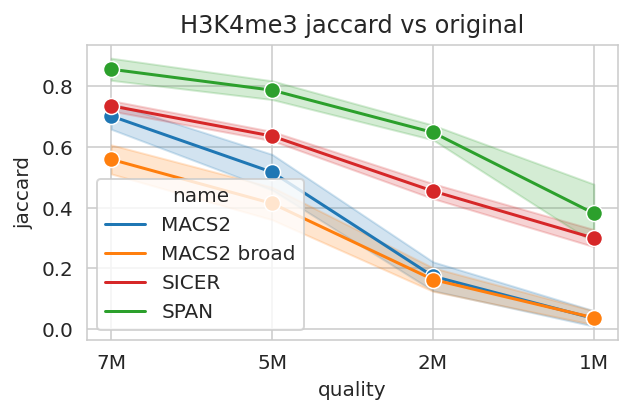

In [20]:
mln_bench_df['q'] = 0
for i, mln in enumerate([7, 5, 2, 1]):
    mln_bench_df.loc[mln_bench_df['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=mln_bench_df,
                         x='q', y='jaccard', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(4), minor=False)
g_results.axes.set_xticklabels(['7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 jaccard vs original')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [21]:
mln_bench_df['modification'] = 'H3K4me3'
mln_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K4me3_mln_bench_df.csv.gz', index=False, compression='gzip')

## Average precision
AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

0it [00:00, ?it/s]

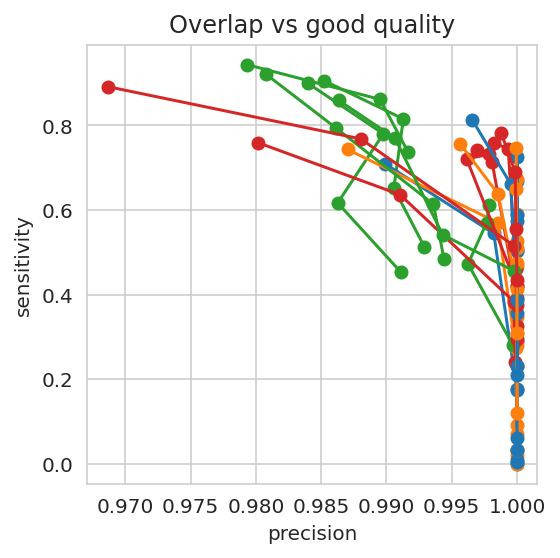

In [22]:
plt.figure(figsize=(4, 4))
for c, r, tool in tqdm(product(mln_bench_df['cell'].unique(),
                               mln_bench_df['replicate'].unique(),
                               mln_bench_df['name'].unique())):
    # print(c, r, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) &
                       (mln_bench_df['replicate'] == r) &
                       (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

0it [00:00, ?it/s]

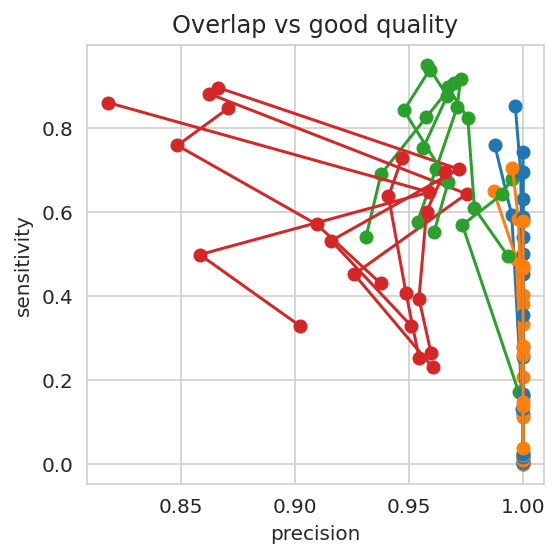

In [23]:
plt.figure(figsize=(4, 4))
for c, r, tool in tqdm(product(mln_bench_df['cell'].unique(),
                               mln_bench_df['replicate'].unique(),
                               mln_bench_df['name'].unique())):
    # print(c, r, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) &
                       (mln_bench_df['replicate'] == r) &
                       (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    plt.plot(dft['precision_len'], dft['sensitivity_len'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_auc_len.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
t = []
for c, r, tool in tqdm(product(mln_bench_df['cell'].unique(),
                               mln_bench_df['replicate'].unique(),
                               mln_bench_df['name'].unique())):
    # print(c, r, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) &
                       (mln_bench_df['replicate'] == r) &
                       (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev) * row['precision']
        rprev = row['sensitivity']
    t.append((c, tool, ap))
dfap = pd.DataFrame(data=t, columns=['cell', 'tool', 'AP'])
dfap

0it [00:00, ?it/s]

,cell,tool,AP
0,GM12878,MACS2,0.504775
1,GM12878,MACS2 broad,0.526357
2,GM12878,SPAN,0.889506
3,GM12878,SICER,0.741340
4,GM12878,MACS2,0.572901
5,GM12878,MACS2 broad,0.591310
6,GM12878,SPAN,0.898143
7,GM12878,SICER,0.758169
8,K562,MACS2,0.706724
9,K562,MACS2 broad,0.740529


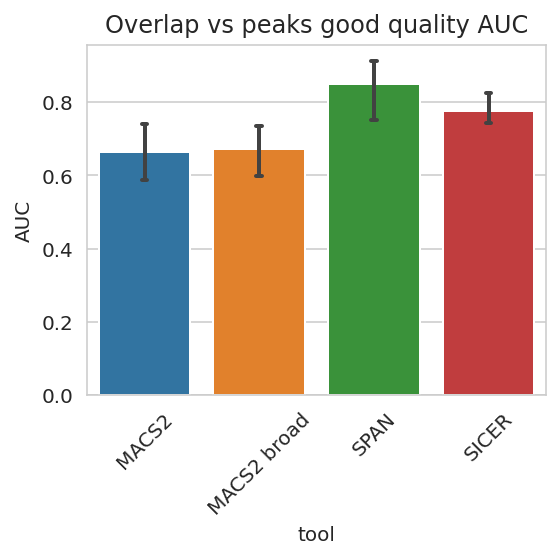

In [25]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfap, x="tool", y="AP", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_ap.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
t = []
for c, r, tool in tqdm(product(mln_bench_df['cell'].unique(),
                               mln_bench_df['replicate'].unique(),
                               mln_bench_df['name'].unique())):
    # print(c, r, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) &
                       (mln_bench_df['replicate'] == r) &
                       (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity_len'] - rprev) * row['precision_len']
        rprev = row['sensitivity_len']
    t.append((c, tool, ap))
dfapl = pd.DataFrame(data=t, columns=['cell', 'tool', 'APL'])
dfapl

0it [00:00, ?it/s]

,cell,tool,APL
0,GM12878,MACS2,0.540670
1,GM12878,MACS2 broad,0.381532
2,GM12878,SPAN,0.853497
3,GM12878,SICER,0.818418
4,GM12878,MACS2,0.630752
5,GM12878,MACS2 broad,0.465701
6,GM12878,SPAN,0.878200
7,GM12878,SICER,0.832437
8,K562,MACS2,0.755289
9,K562,MACS2 broad,0.645973


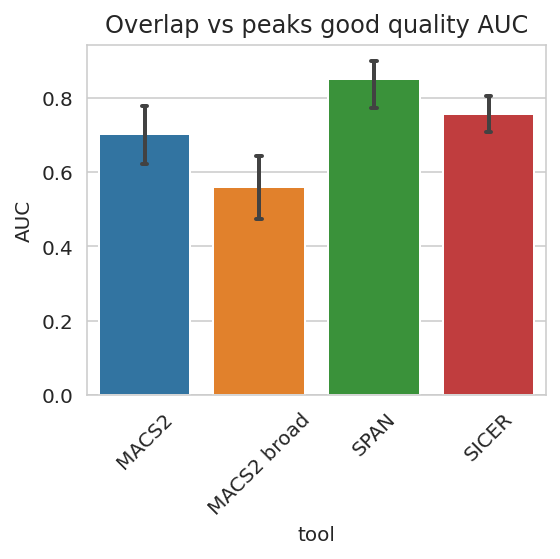

In [27]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfapl, x="tool", y="APL", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_apl.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K4me3

In [28]:
import tempfile
tf = tempfile.mktemp()

ts = []
for mln, c, r in tqdm(product([10, 7, 5, 2, 1], GSE26320_CELLS, GSE26320_REPS)):
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ts.append((c, r, mln, tool, peaks, peaks_len))
        if tool == 'SPAN':
            span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            ts.append((c, r, mln, name, peaks, peaks_len))

bench_df = pd.DataFrame(data=ts, columns=['cell', 'replicate', 'quality', 'name', 'peaks', 'length'])
del ts
bench_df.sample(3)

0it [00:00, ?it/s]

,cell,replicate,quality,name,peaks,length
10,GM12878,rep2,10,MACS2,38141,33961060
25,HMEC,rep1,10,MACS2 - SPAN,0,0
102,NHLF,rep2,10,SPAN,25646,43156567


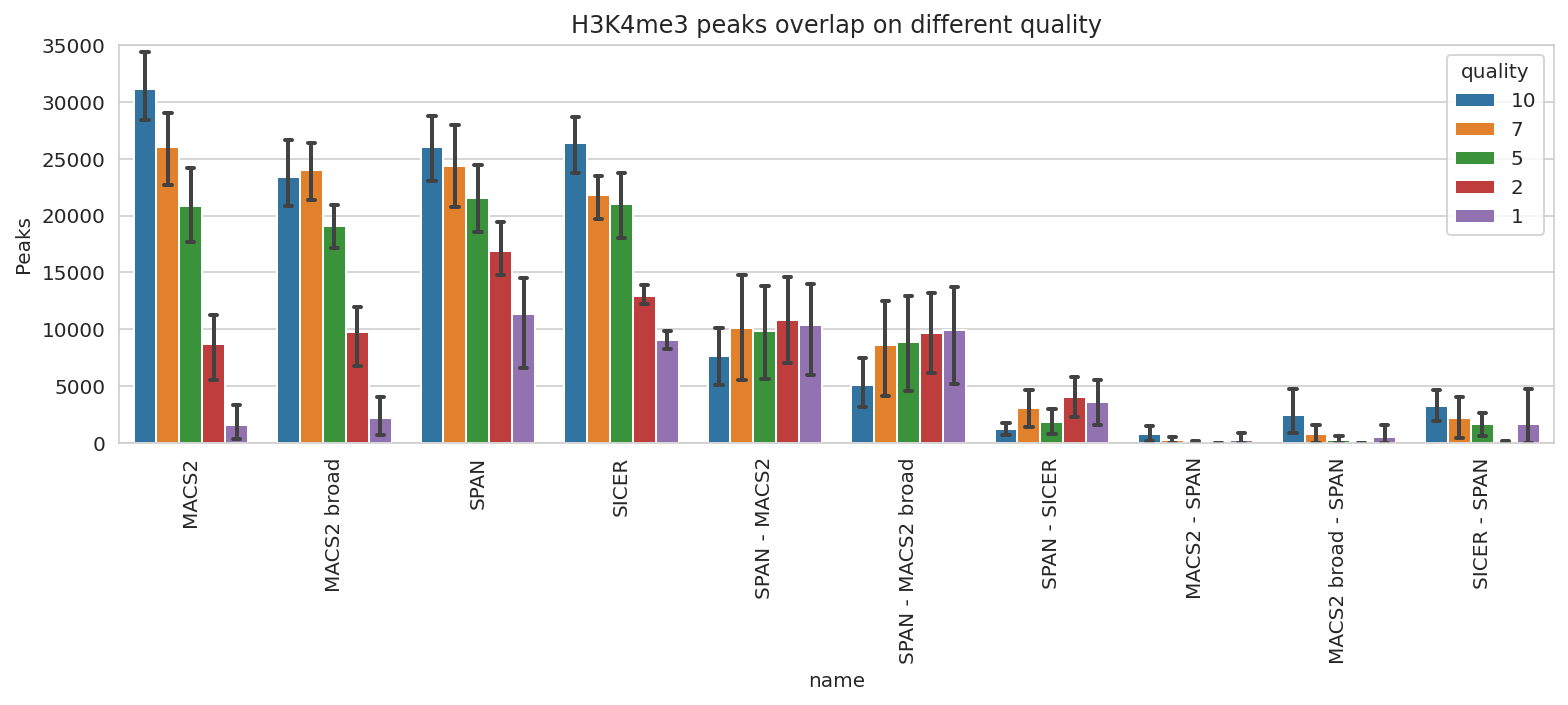

In [29]:
plt.figure(figsize=(11, 5))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[10, 7, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K4me3 peaks overlap on different quality')
ax.set_ylabel('Peaks')
ax.set_ylim([0, 35_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

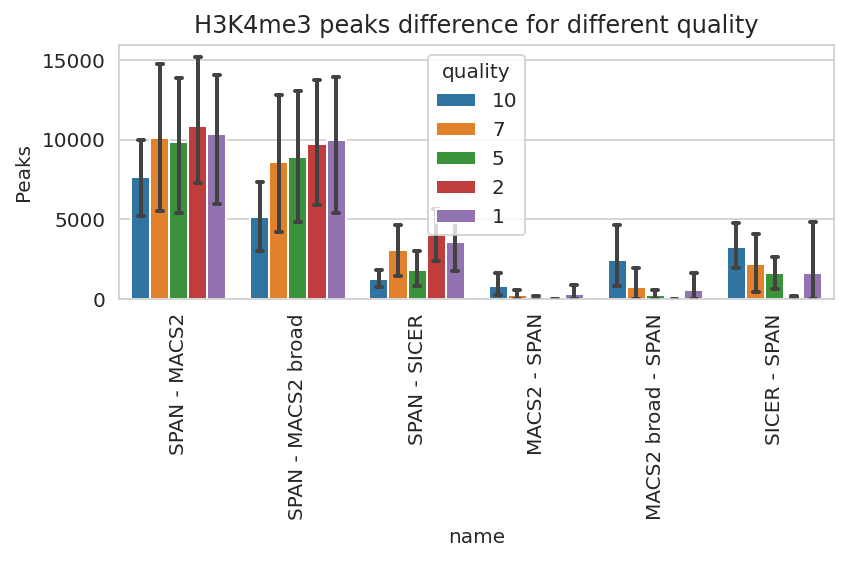

In [30]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[10, 7, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K4me3 peaks difference for different quality')
ax.set_ylabel('Peaks')
# ax.set_ylim([0, 20_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_overlap_diff.pdf', bbox_inches='tight', dpi=300)
plt.show()

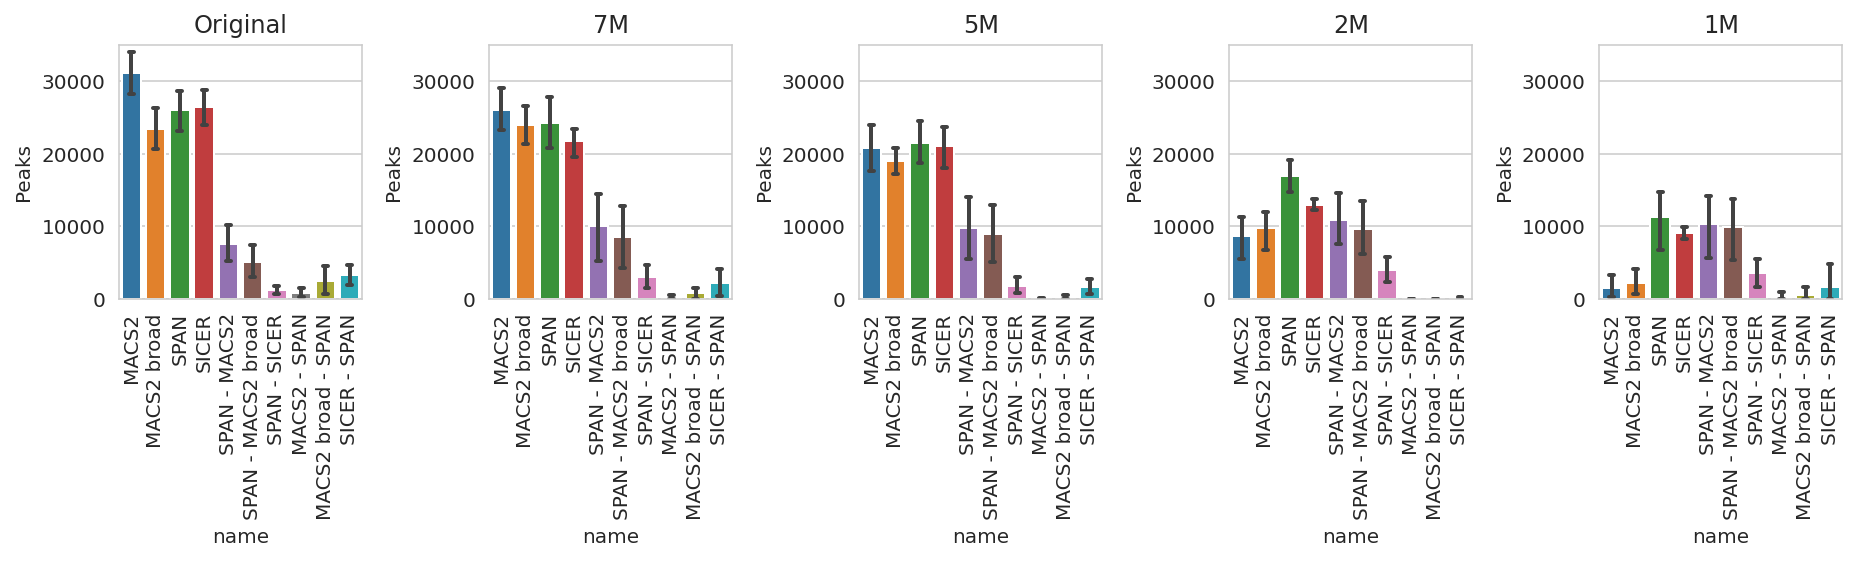

In [31]:
plt.figure(figsize=(13, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, mln in enumerate([10, 7, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['quality']==mln],
                            x='name', y='peaks', ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ])
    ax.title.set_text(f'{mln}M' if mln != 10 else 'Original')
    ax.set_ylabel('Peaks')
    ax.set_ylim([0, 35_000])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_overlap_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Coverage

In [32]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = os.path.expanduser('~/data/2023_GSE26320') + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        r = next((rr for rr in GSE26320_REPS if rr in f), None)
        if cell and r and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, r)
    return df_bws

In [33]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K4me3')
display(bws_df.sample(2))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Input')
display(bws_control_df.sample(2))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64634...,H3K4me3,H1,rep2
15,/home/jetbrains/data/2023_GSE26320/bw/GSM64644...,H3K4me3,K562,rep2


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
11,/home/jetbrains/data/2023_GSE26320/bw/GSM64637...,Input,HepG2,rep1
4,/home/jetbrains/data/2023_GSE26320/bw/GSM64649...,Input,NHLF,rep1


In [34]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

In [35]:
import pyBigWig

tf = tempfile.mktemp()

coverage_data = []

for mln, c, r in tqdm(product([10, 7, 5, 2, 1], GSE26320_CELLS, GSE26320_REPS)):
    print(mln, c, r)
    t = bws_df[(bws_df['modification'] == 'H3K4me3') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]

    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', mln, c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', mln, c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', mln, c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', mln, c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'quality', 'cell', 'replicate',
             'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

10 GM12878 rep1
10 GM12878 rep2
10 HMEC rep1
10 HMEC rep2
10 HSMM rep1
10 HSMM rep2
10 K562 rep1
10 K562 rep2
10 NHEK rep1
10 NHEK rep2
10 NHLF rep1
10 NHLF rep2
10 H1 rep1
10 H1 rep2
10 Huvec rep1
10 Huvec rep2
10 HepG2 rep1
10 HepG2 rep2
7 GM12878 rep1
7 GM12878 rep2
7 HMEC rep1
7 HMEC rep2
7 HSMM rep1
7 HSMM rep2
7 K562 rep1
7 K562 rep2
7 NHEK rep1
7 NHEK rep2
7 NHLF rep1
7 NHLF rep2
7 H1 rep1
7 H1 rep2
7 Huvec rep1
7 Huvec rep2
7 HepG2 rep1
7 HepG2 rep2
5 GM12878 rep1
5 GM12878 rep2
5 HMEC rep1
5 HMEC rep2
5 HSMM rep1
5 HSMM rep2
5 K562 rep1
5 K562 rep2
5 NHEK rep1
5 NHEK rep2
5 NHLF rep1
5 NHLF rep2
5 H1 rep1
5 H1 rep2
5 Huvec rep1
5 Huvec rep2
5 HepG2 rep1
5 HepG2 rep2
2 GM12878 rep1
2 GM12878 rep2
2 HMEC rep1
2 HMEC rep2
2 HSMM rep1
2 HSMM rep2
2 K562 rep1
2 K562 rep2
2 NHEK rep1
2 NHEK rep2
2 NHLF rep1
2 NHLF rep2
2 H1 rep1
2 H1 rep2
2 Huvec rep1
2 Huvec rep2
2 HepG2 rep1
2 HepG2 rep2
1 GM12878 rep1
1 GM12878 rep2
1 HMEC rep1
1 HMEC rep2
1 HSMM rep1
1 HSMM rep2
1 K562 rep1
1 K5

,modification,quality,cell,replicate,name,position,length,type,coverage,total_coverage
3549276,H3K4me3,10,Huvec,rep1,SICER - SPAN,chr1:66542600-66546399,3799,control,1500.0,3.525940e+08
7170834,H3K4me3,2,K562,rep1,SPAN,chr12:50166500-50167964,1464,treatment,15906.0,1.066939e+09
6887979,H3K4me3,2,GM12878,rep1,SPAN - MACS2,chr11:47981109-47988085,6976,control,1900.0,5.619779e+08
4761488,H3K4me3,7,K562,rep1,MACS2 broad,chrX:41332435-41333206,771,control,255.0,5.900140e+08
4122175,H3K4me3,7,GM12878,rep1,MACS2,chr6:69865895-69867264,1369,control,0.0,5.619128e+08


In [36]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

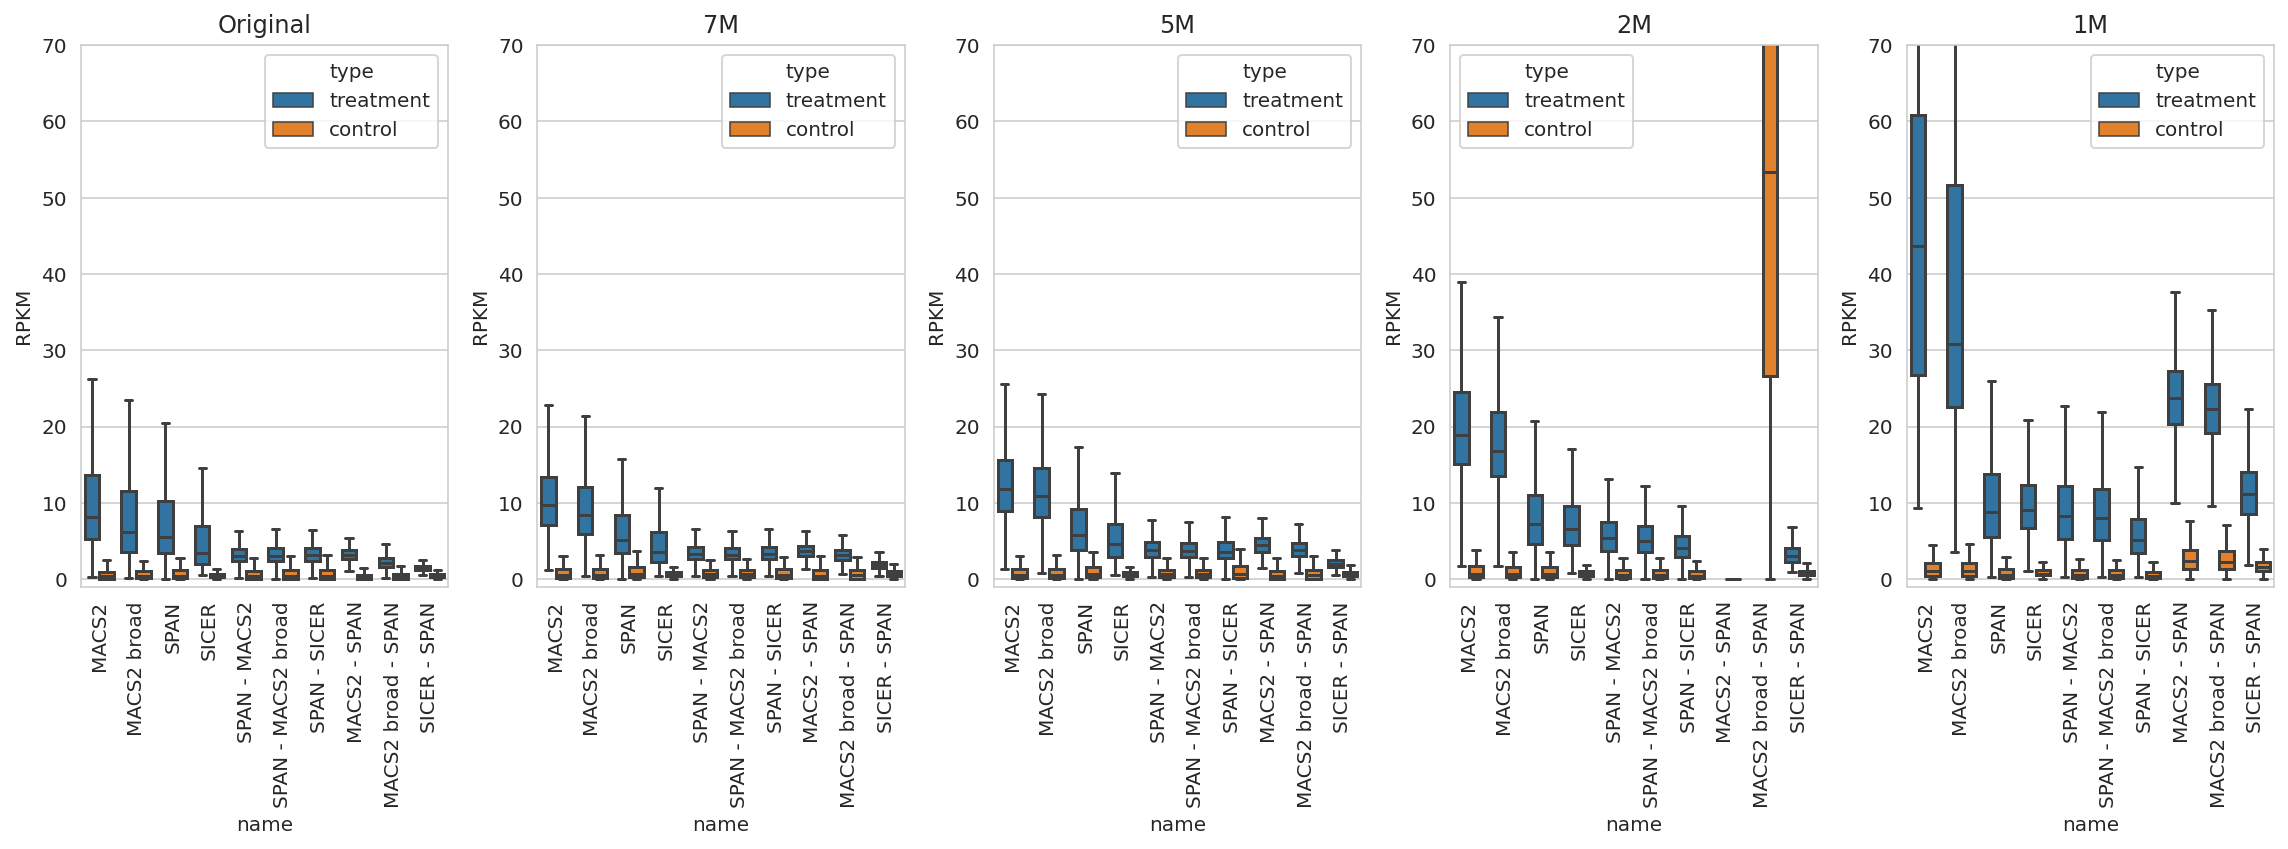

In [37]:
plt.figure(figsize=(16, 6))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, mln in enumerate([10, 7, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=df_coverage[df_coverage['quality'] == mln],
                            x='name', y='rpkm', hue='type',
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ],
                            showfliers=False, ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('RPKM')
    ax.set_ylim(-1, 70)
    ax.title.set_text(f'{mln}M' if mln != 10 else 'Original')

plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

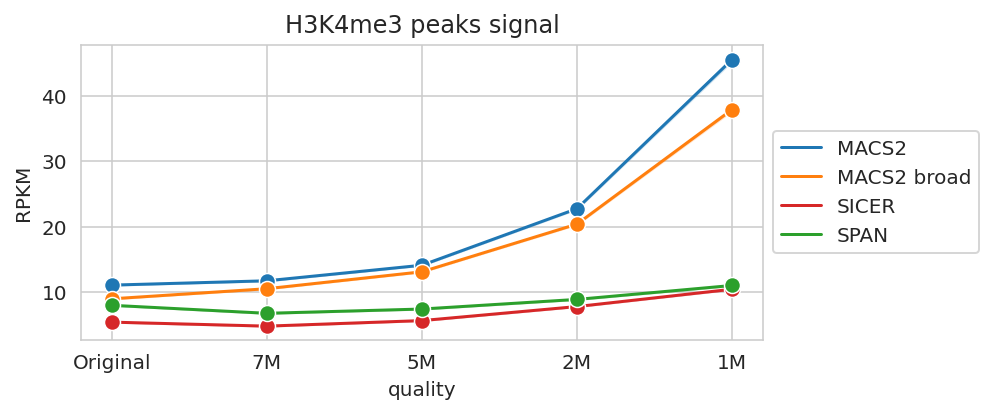

In [38]:
t = df_coverage[(df_coverage['name'].isin(['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])) &
                (df_coverage['type'] == 'treatment')].copy()
t['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(7, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='rpkm', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.set_ylabel('RPKM')
g_results.axes.title.set_text(f'H3K4me3 peaks signal')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_coverage2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Ratio on SPAN and other tool peaks overlap

In [39]:
import tempfile

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'replicate', 'quality', 'tool', 'span_overlap_peaks', 'tool_overlap_peaks'], dtype=object)

for mln, c, r in tqdm(product([10, 7, 5, 2, 1], GSE26320_CELLS, GSE26320_REPS)):
    t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                     (df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(span_file) == 0 or lines(peaks_file) == 0:
            continue
        span_cols = len(pd.read_csv(span_file, sep='\t', header=None, nrows=1).columns)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -wb > {tf}
        try:
            overlap = pd.read_csv(tf, sep='\t', header=None)
            span_overlap_peaks = len(overlap.groupby([0, 1, 2]).count())
            tool_overlap_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
            ratio_df.loc[len(ratio_df)] = (c, r, mln, tool, span_overlap_peaks, tool_overlap_peaks)
        except:
            pass
ratio_df

0it [00:00, ?it/s]

,cell,replicate,quality,tool,span_overlap_peaks,tool_overlap_peaks
0,GM12878,rep1,10,MACS2,19926,41107
1,GM12878,rep1,10,MACS2 broad,26735,28696
2,GM12878,rep1,10,SICER,31826,30281
3,GM12878,rep2,10,MACS2,20126,38112
4,GM12878,rep2,10,MACS2 broad,25581,27033
...,...,...,...,...,...,...
112,K562,rep2,1,MACS2 broad,1745,1945
113,K562,rep2,1,SICER,8736,8802
114,Huvec,rep2,1,MACS2,4419,5946
115,Huvec,rep2,1,MACS2 broad,5149,6583


In [40]:
ratio_df['tool_to_span'] = ratio_df['tool_overlap_peaks'] / ratio_df['span_overlap_peaks']

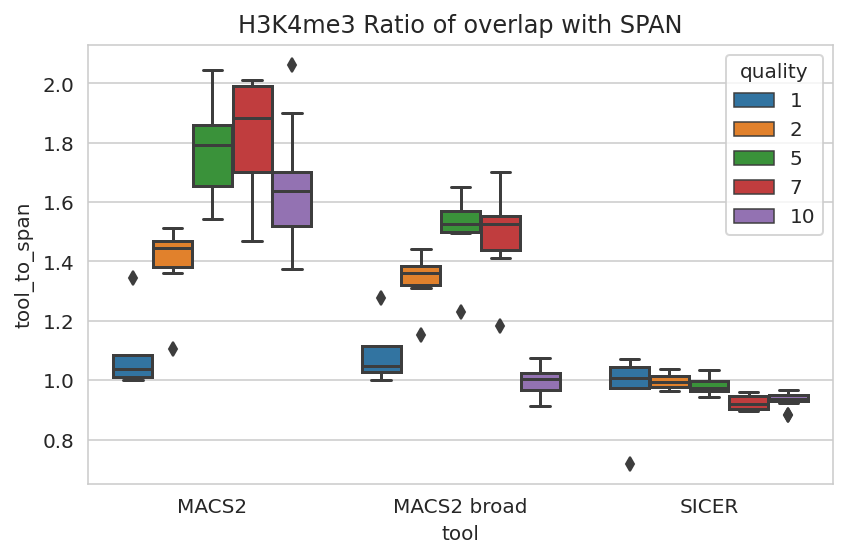

In [41]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, y='tool_to_span', x='tool', ax=ax, hue='quality',
                        # palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'])
ax.title.set_text('H3K4me3 Ratio of overlap with SPAN')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_ratio_overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

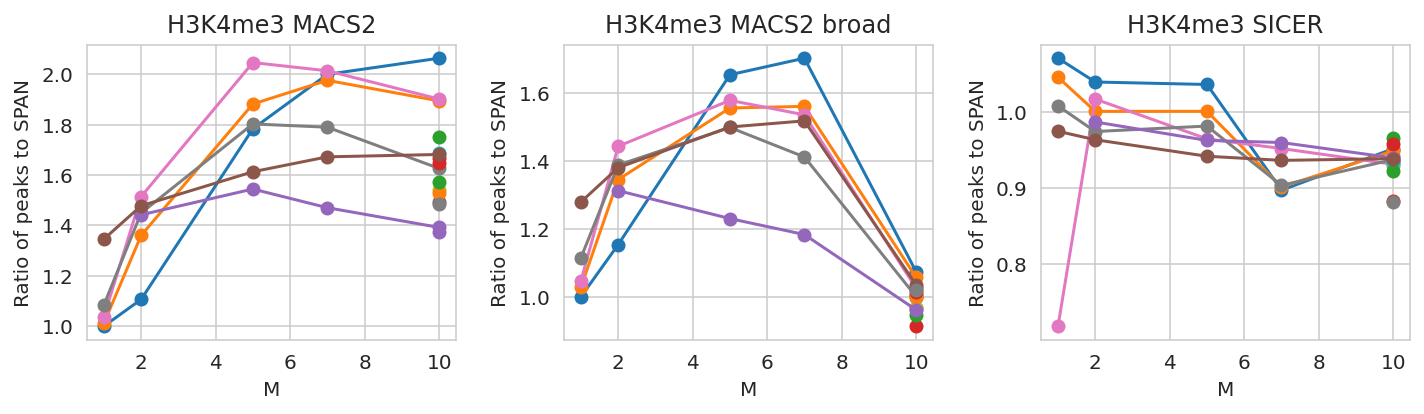

In [42]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    for cell, r in product(GSE26320_CELLS, GSE26320_REPS):
        tt = ratio_df[(ratio_df['cell'] == cell) &
                      (ratio_df['replicate'] == r) &
                      (ratio_df['tool'] == tool)]
        ax.plot(tt['quality'], tt['tool_to_span'], marker='o', label=t)
    ax.title.set_text(f'H3K4me3 {tool}')
    ax.set_ylabel('Ratio of peaks to SPAN')
    ax.set_xlabel('M')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_ratio_overlap2.pdf', bbox_inches='tight', dpi=300)
plt.show()

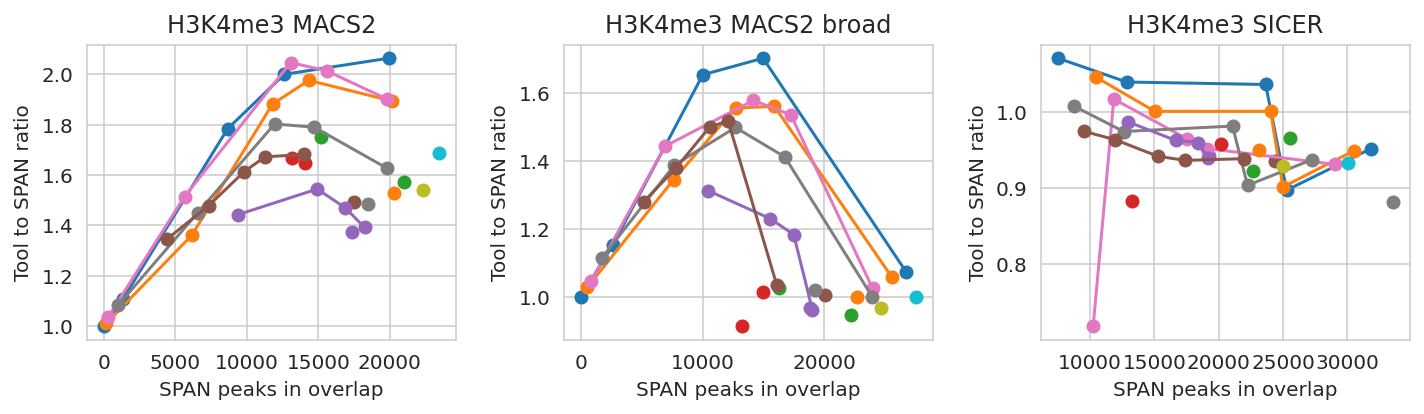

In [43]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    for cell, r in product(GSE26320_CELLS, GSE26320_REPS):
        tt = ratio_df[(ratio_df['cell'] == cell) &
                      (ratio_df['replicate'] == r) &
                      (ratio_df['tool'] == tool)]
        ax.plot(tt['span_overlap_peaks'], tt['tool_to_span'], marker='o', label=t)
    ax.title.set_text(f'H3K4me3 {tool}')
    ax.set_xlabel('SPAN peaks in overlap')
    ax.set_ylabel('Tool to SPAN ratio')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_ratio_overlap3.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Replicates consistency

In [44]:
reps_overlap = pd.DataFrame(columns=['modification', 'quality', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len', 'diff1', 'diff2'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for mln, c, m in tqdm(product([10, 7, 5, 2, 1], GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                      (df_fdr_peaks['cell'] == c) &
                      (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                if len(t1) != 1 or len(t2) != 1:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wa -v > {tf}
                diff1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -v > {tf}
                diff2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, mln, c, tool, rep1, rep2,
                     peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap2, overlap_len, diff1, diff2)


reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
]
reps_overlap['jaccardp'] = [
    d(o1 + o2, d1 + d2 + o1 + o2)
    for o1, o2, d1, d2 in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1_overlap'],
                              reps_overlap['diff1'], reps_overlap['diff2'])
]
reps_overlap.sample(5)

0it [00:00, ?it/s]

GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3
GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3
GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3
GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3
GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3


,modification,quality,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,diff1,diff2,jaccard,jaccardp
64,H3K4me3,1,GM12878,MACS2,rep1,rep2,3,997,171,60574,0,0,0,3,171,0.000000,0.000000
43,H3K4me3,5,GM12878,SPAN,rep1,rep2,26374,68978224,26072,64491753,21381,21615,53003532,4993,4457,0.658704,0.819007
44,H3K4me3,5,K562,MACS2,rep1,rep2,26907,17752930,21533,14120185,19019,18676,11338184,7888,2857,0.552141,0.779739
17,H3K4me3,10,NHEK,MACS2 broad,rep1,rep2,40028,62002403,27886,42087690,22675,23454,35185217,17353,4432,0.510635,0.675505
63,H3K4me3,2,Huvec,SPAN,rep1,rep2,14348,22792420,13882,23701892,11514,11660,17735705,2834,2222,0.616709,0.819969


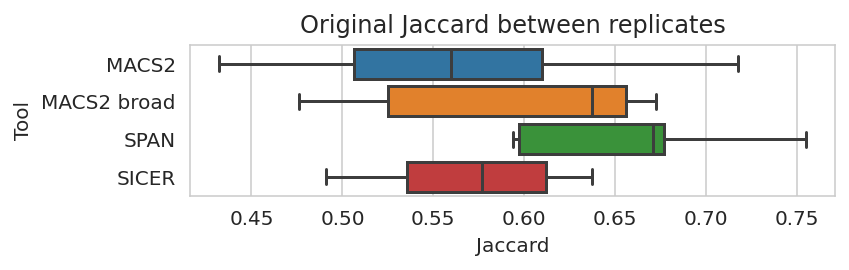

In [45]:
plt.figure(figsize=(6, 2))
g_result = sns.boxplot(data=reps_overlap[reps_overlap['quality'] == 10],
                       y='tool', x='jaccard', palette=TOOLS_PALETTE, order=TOOLS,
                       showfliers=False)
ax = g_result.axes
ax.set_title('Original Jaccard between replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')
plt.tight_layout()
plt.show()

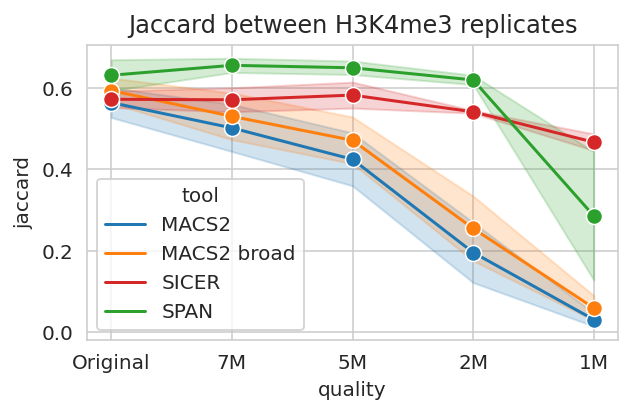

In [46]:
reps_overlap['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    reps_overlap.loc[reps_overlap['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=reps_overlap,
                         x='q', y='jaccard', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'Jaccard between H3K4me3 replicates')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_replicates_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

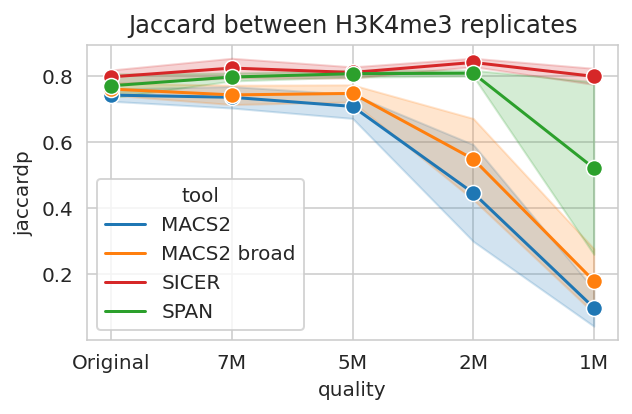

In [47]:
reps_overlap['q'] = 0
for i, mln in enumerate([10, 7, 5, 2, 1]):
    reps_overlap.loc[reps_overlap['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=reps_overlap,
                         x='q', y='jaccardp', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['Original', '7M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'Jaccard between H3K4me3 replicates')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_replicates_jaccard3.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [48]:
reps_overlap['modification'] = 'H3K4me3'
reps_overlap.to_csv(GSE26320_PATH_HG38 + '/H3K4me3_replicates_df.csv', index=False)